In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


from NEID_solar_functions import *
from GP_kernels import *


In [2]:
#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('./data_v4/v_grid.txt')
CCF     = np.loadtxt('./data_v4/CCF.txt')
σCCF   = np.loadtxt('./data_v4/σCCF.txt')
bjd     = np.loadtxt('./data_v4/bjd.txt')
rv      = np.loadtxt('./data_v4/rv.txt')
σrv     = np.loadtxt('./data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('idx_rej'), dtype=bool)

303.62073697149754
122


Text(-6.504999999999988, 0.5, 'Density')

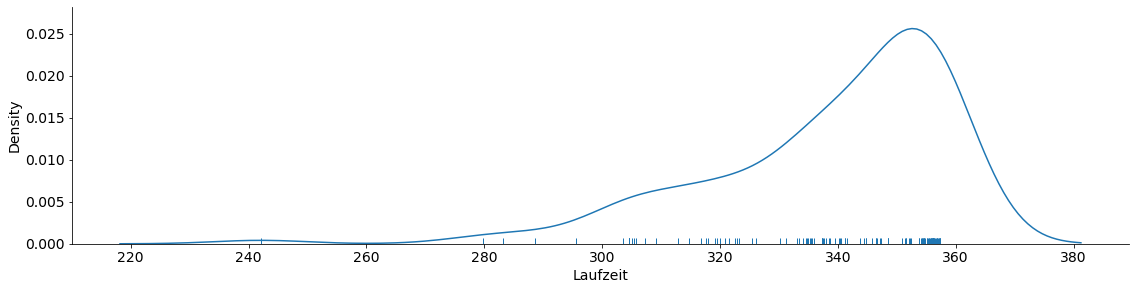

In [3]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

Laufzeit = []
delta_t_min = 400
for date in daterange(start_date, end_date):
    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    
    if (len(bjd[idx_bjd])>150):
        t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
        delta_t = max(t) - min(t)
        Laufzeit.append(delta_t)
        
        if delta_t>300:
            if (delta_t_min > delta_t):
                delta_t_min = delta_t
            
print(delta_t_min)
print(len(Laufzeit))

%matplotlib inline
import seaborn as sns

plt.rcParams.update({'font.size': 14})
sns.displot(data=Laufzeit,  kind="kde", rug=True, height=4, aspect=4)
plt.xlabel('Laufzeit')
plt.ylabel('Density')
        

In [4]:
%matplotlib inline
from scipy.signal import hilbert, chirp

def moving_ave(t, y, width=2):
    w_aves = []
    for t_i in t:
        weights = stats.norm.pdf(t, t_i, width)
        # weights = np.multiply(abs(array_x-t_i)<width, 1) 
        w_ave, _ = weighted_avg_and_std(y, weights)
        w_aves.append(w_ave)
        # w_stds.append(w_std)
    return np.array(w_aves)
        

# start_date = datetime(2021, 5, 28)
# end_date = datetime(2021, 6, 10)
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

# beats_widths = np.array([])
beats_heights = np.array([])
beats_centres = np.array([])
days = np.array([])

beats_widths_by_day = []
beats_heights_by_day = []
beats_centres_by_day = []

Day = []
Amplitude_envelopes = np.array([])
Cov_XYs = np.array([])

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    
    if (len(bjd[idx_bjd])>150):

        t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
        delta_t = max(t) - min(t)
        
        if delta_t>300:

            y = rv[idx_bjd] - np.mean(rv[idx_bjd])
        
            # new
            idx_h = (t<=max(t)-0) & (t>=0)
            t = t[idx_h]
            y = y[idx_h]
            yerr = σrv[idx_bjd][idx_h]
            # new

            if 0:
                reg = LinearRegression().fit(t.reshape((-1, 1)), y)
                y = y - reg.predict(t.reshape((-1, 1)))
                yerr = σrv[idx_bjd]
                # yerr = (yerr**2 + 0.25**2)**0.5 # new        
            if 1:
                poly_para = np.polyfit(t, y, 2)
                predict_func = np.poly1d(poly_para)
                y = y - predict_func(t)

            gp = GP_fit_p1(t, y, yerr, p=5.2)

            ############
            # plotting #
            ############
#             fig = plt.figure(figsize=(15, 6))
#             plt.subplots_adjust(right=0.85, hspace=0.3)
#             plt.rcParams.update({'font.size': 14})

#             ## Upper panel    
#             fig.add_subplot(211)
#             plt.title(str(date)[:10])
#             plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
#             # plt.plot(t, predict_func(t), lw=3, alpha=0.3)
#             x = np.linspace(min(t), max(t), 1000)
#             pred_mean, pred_var = gp.predict(y, x, return_var=True)
#             pred_std = np.sqrt(pred_var)        
#             plt.plot(x, pred_mean, color='k', alpha=0.3)
#             plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
#                              edgecolor="none")
#             plt.xlabel("Time [min]")
#             plt.ylabel("RV [m/s]")

            ## Lower panel 
            Delta_t = np.linspace(0, 300, 1201)
            cov_XY = []
            
            # new
            
            for delta_t in Delta_t:
                t_cov = np.linspace(0, max(t)-delta_t, 300)
                X, _ = gp.predict(y, t_cov, return_var=False)
                # X = y[t<(max(t)-delta_t)]
                Y, _ = gp.predict(y, t_cov+delta_t, return_var=False)
                cov_XY.append(cov(X, Y))
            # new
            
            # for delta_t in Delta_t:
            #     X = y[t<(max(t)-delta_t)]
            #     Y, _ = gp.predict(y, t[t<(max(t)-delta_t)]+delta_t, return_var=False)
            #     cov_XY.append(cov(X, Y))
            # cov_XY = np.array(cov_XY)
            
            analytic_signal = hilbert(cov_XY)
            amplitude_envelope = np.abs(analytic_signal)
            amplitude_envelope = moving_ave(Delta_t, amplitude_envelope, width=5) 
            peaks1, prop1 = find_peaks(amplitude_envelope, height=0.01)  # local max 
            peaks2, prop2 = find_peaks(-amplitude_envelope, height=-10) # local min 
            if len(Amplitude_envelopes) == 0:
                Amplitude_envelopes = amplitude_envelope
                Cov_XYs = cov_XY
            else:
                Amplitude_envelopes = np.vstack((Amplitude_envelopes, amplitude_envelope))
                Cov_XYs = np.vstack((Cov_XYs, cov_XY))

            # fig.add_subplot(212)
            # plt.plot(Delta_t, cov_XY, 'k.-', alpha=0.5)
            # plt.plot(Delta_t, amplitude_envelope, 'm', lw=3, alpha=0.4)
            # plt.plot(Delta_t, -amplitude_envelope, 'm', lw=3, alpha=0.4)
            # plt.plot(Delta_t[peaks1], prop1['peak_heights'], 'o', color='green', markersize=8)
            # plt.plot(Delta_t[peaks1], -prop1['peak_heights'], 'o', color='green', markersize=8)
            # plt.plot(Delta_t[peaks2], prop2['peak_heights'], 'o', color='red', markersize=8)
            # plt.plot(Delta_t[peaks2], -prop2['peak_heights'], 'o', color='red', markersize=8)    
            # plt.xlabel(r'$\Delta$T [minutes]')
            # plt.ylabel(r'Covariance [m$^2$/s$^2$]')
            # plt.grid()    

            # plt.savefig('./figure2/'+str(date)[:10]+'.png')
            # plt.show()



            if 0:
                if len(prop1['peak_heights']) == len(np.diff(Delta_t[peaks2])):
                    beats_heights = np.hstack((beats_heights, prop1['peak_heights']))
                    beats_widths = np.hstack((beats_widths, np.diff(Delta_t[peaks2])))
                    beats_centres = np.hstack((beats_centres, Delta_t[peaks1]))

                if len(prop1['peak_heights']) == (len(np.diff(Delta_t[peaks2]))+1):
                    beats_heights = np.hstack((beats_heights, prop1['peak_heights'][:-1]))
                    beats_widths = np.hstack((beats_widths, np.diff(Delta_t[peaks2])))    
                    beats_centres = np.hstack((beats_centres, Delta_t[peaks1][:-1]))    

            if 1: # just getting the envelope peak centre position 
                beats_centres = np.hstack((beats_centres, Delta_t[peaks1]))
                beats_heights = np.hstack((beats_heights, prop1['peak_heights']))
                days = np.hstack((  days, T1*np.ones( len(Delta_t[peaks1]) )   ))
                beats_centres_by_day.append(Delta_t[peaks1])
                beats_heights_by_day.append(prop1['peak_heights'])
                Day.append(T1)


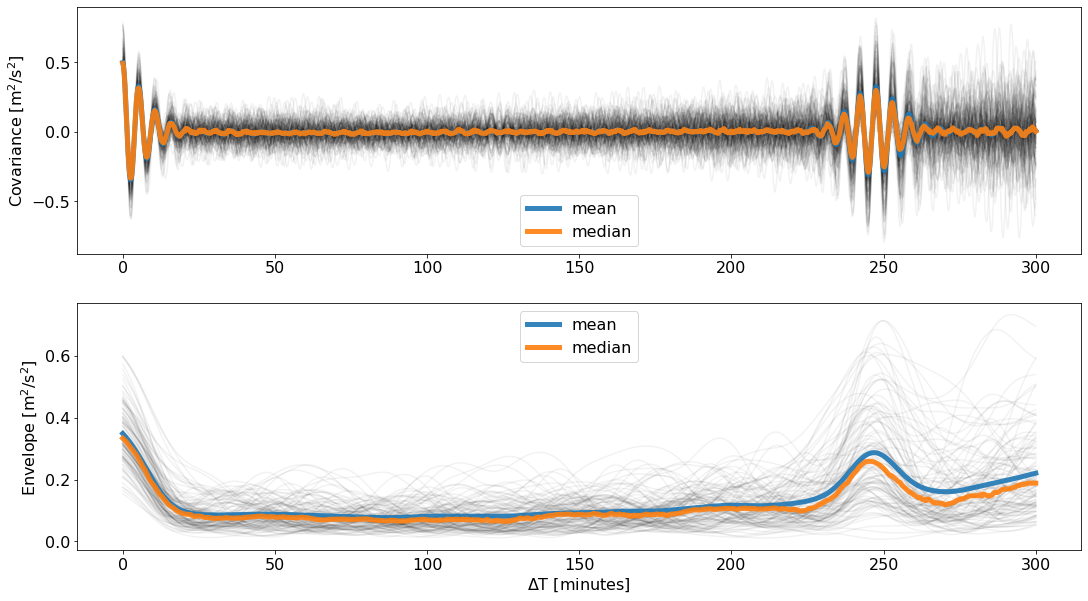

In [5]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 10))
fig.add_subplot(211)
plt.plot(Delta_t, Cov_XYs.T, 'k', alpha=0.05)
plt.plot(Delta_t, np.mean(Cov_XYs, axis=0), lw=5, alpha=0.9, label='mean')
plt.plot(Delta_t, np.median(Cov_XYs, axis=0), lw=5, alpha=0.9, label='median')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()

fig.add_subplot(212)
plt.plot(Delta_t, Amplitude_envelopes.T, 'k', alpha=0.05)
plt.plot(Delta_t, np.mean(Amplitude_envelopes, axis=0), lw=5, alpha=0.9, label='mean')
plt.plot(Delta_t, np.median(Amplitude_envelopes, axis=0), lw=5, alpha=0.9, label='median')
plt.xlabel(r'$\Delta$T [minutes]')
plt.ylabel(r'Envelope [m$^2$/s$^2$]')
plt.legend()
plt.savefig('./0902/cov_env_0.png')
plt.show()

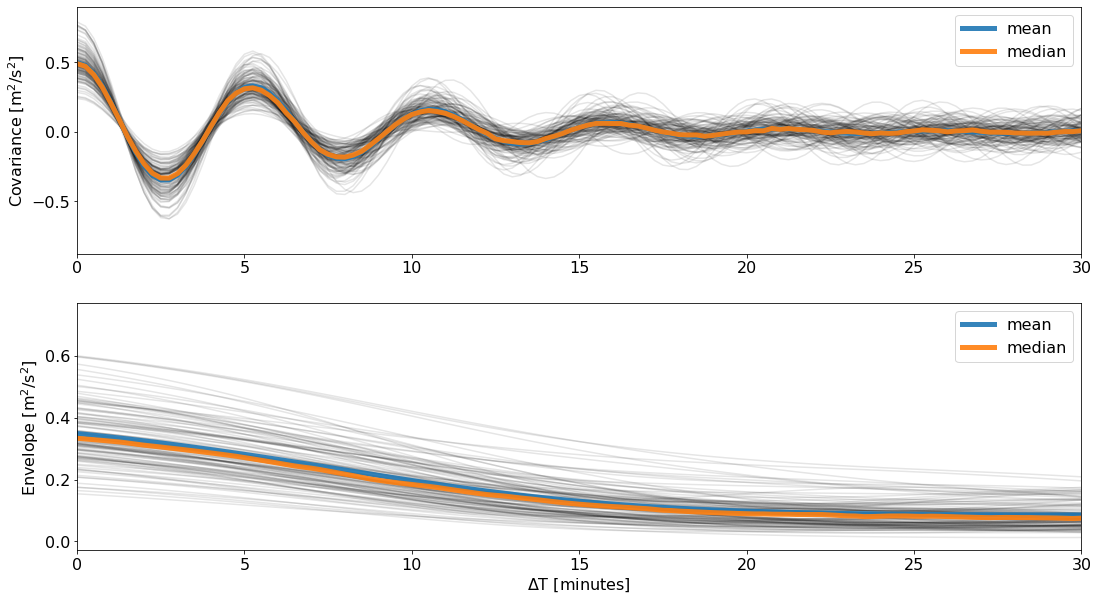

In [6]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 10))
fig.add_subplot(211)
plt.plot(Delta_t, Cov_XYs.T, 'k', alpha=0.1)
plt.plot(Delta_t, np.mean(Cov_XYs, axis=0), lw=5, alpha=0.9, label='mean')
plt.plot(Delta_t, np.median(Cov_XYs, axis=0), lw=5, alpha=0.9, label='median')
plt.xlim([0,30])
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()

fig.add_subplot(212)
plt.plot(Delta_t, Amplitude_envelopes.T, 'k', alpha=0.1)
plt.plot(Delta_t, np.mean(Amplitude_envelopes, axis=0), lw=5, alpha=0.9, label='mean')
plt.plot(Delta_t, np.median(Amplitude_envelopes, axis=0), lw=5, alpha=0.9, label='median')
plt.xlim([0,30])
plt.xlabel(r'$\Delta$T [minutes]')
plt.ylabel(r'Envelope [m$^2$/s$^2$]')
plt.legend()
plt.savefig('./0902/cov_env_0_a.png')
plt.show()

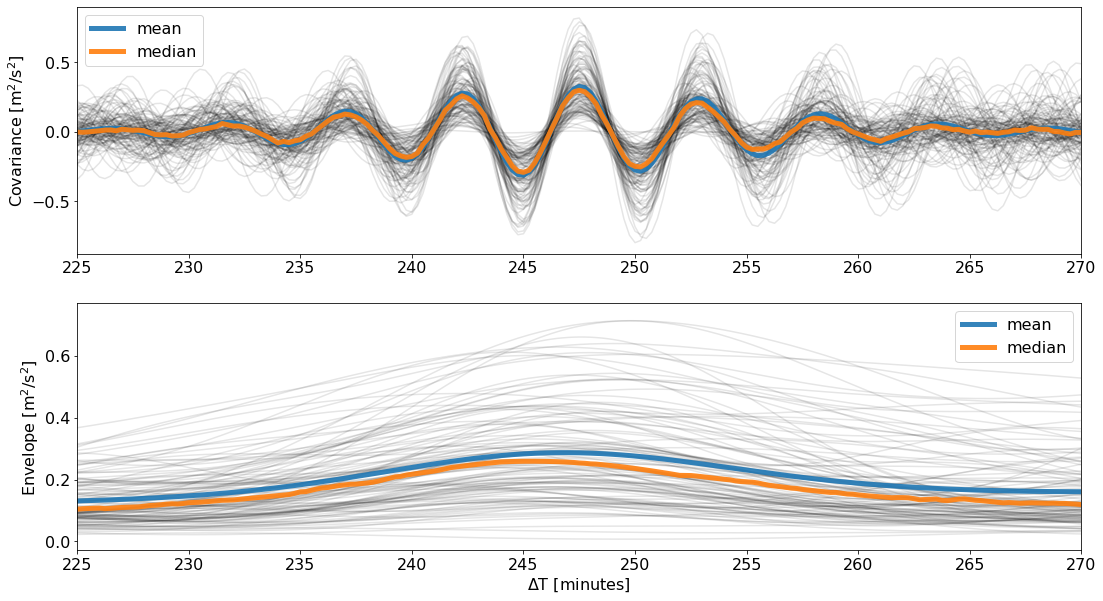

In [7]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 10))
fig.add_subplot(211)
plt.plot(Delta_t, Cov_XYs.T, 'k', alpha=0.1)
plt.plot(Delta_t, np.mean(Cov_XYs, axis=0), lw=5, alpha=0.9, label='mean')
plt.plot(Delta_t, np.median(Cov_XYs, axis=0), lw=5, alpha=0.9, label='median')
plt.xlim([225,270])
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()

fig.add_subplot(212)
plt.plot(Delta_t, Amplitude_envelopes.T, 'k', alpha=0.1)
plt.plot(Delta_t, np.mean(Amplitude_envelopes, axis=0), lw=5, alpha=0.9, label='mean')
plt.plot(Delta_t, np.median(Amplitude_envelopes, axis=0), lw=5, alpha=0.9, label='median')
plt.xlim([225,270])
plt.xlabel(r'$\Delta$T [minutes]')
plt.ylabel(r'Envelope [m$^2$/s$^2$]')
plt.legend()
plt.savefig('./0902/cov_env_0_b.png')
plt.show()

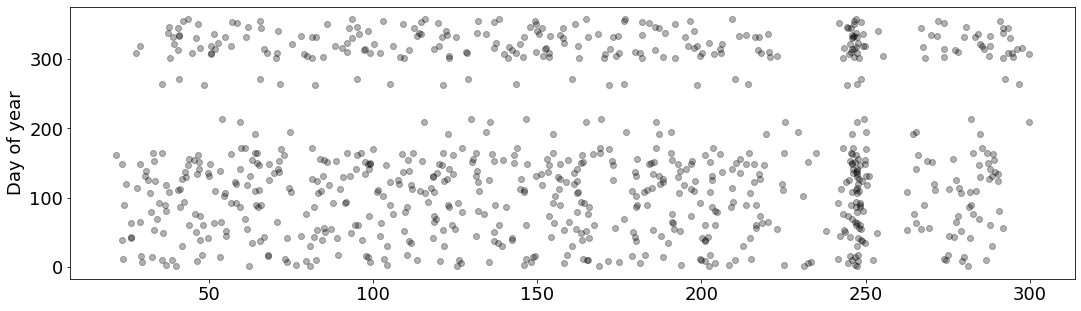

NameError: name 't_plot' is not defined

<Figure size 1296x360 with 0 Axes>

In [8]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(18, 5))
# fig.add_subplot(211)
for i in range(len(Day)):
    plt.plot(beats_centres_by_day[i], (Day[i]-Day[0]+1)*np.ones( len(beats_centres_by_day[i])   ), 'ko', alpha=0.3)
    
    plt.ylabel('Day of year')
    # plt.ylim([200, 300])
plt.savefig('./0902/Envelope peak location.png')   
plt.show()

from matplotlib import colors
fig = plt.figure(figsize=(18,5))
# fig.add_subplot(212)
plt.pcolor(t_plot, widths, np.transpose(y_plots), cmap=plt.cm.get_cmap('Reds'), 
           norm=colors.LogNorm(vmin=5, vmax=y_plots.max()/15))
plt.xticks(np.arange(0, max(t_plot), 20))
plt.xlabel('Envelope peak location [minutes]')
plt.ylabel('Smoothing width')
plt.colorbar()
plt.savefig('./0902/Envelope peak location density.png')   
plt.show()


plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 8))
plt.scatter(beats_heights, beats_centres, c = 'k', marker='o', alpha=0.3)
plt.xlabel('heights')
plt.ylabel(r'$\Delta T$')
plt.show()

In [ ]:
y_plots.max()

In [ ]:
def moving_sum(t, data, width=2):
    w_aves = []
    for t_i in t:
        weights = stats.norm.pdf(data, t_i, width)
        w_aves.append(sum(weights))
    return np.array(w_aves)

In [ ]:
# Density Plot with Rug Plot
%matplotlib inline
import seaborn as sns

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(15, 8))
fig.add_subplot(211)
# sns.displot(data=beats_centres,  kind="kde", rug=True, bw=5, height=10, aspect=1)
sns.kdeplot(beats_centres, shade=True, bw_method=0.05, bw_adjust=.05, color="olive")

# Plot formatting
plt.xlabel(r'$\Delta T$')
plt.ylabel('Density')

fig.add_subplot(212)
width = 0.1
t_plot = np.linspace(min(beats_centres), max(beats_centres), len(beats_centres))
y_plot = moving_sum(t_plot, beats_centres, width=width)
plt.xlabel(r'$\Delta T$')
plt.ylabel('Density')
plt.plot(t_plot, y_plot*width**0.5)
plt.ylim([0, max(y_plot*width**0.5)*1.1])
plt.show()

In [ ]:
%matplotlib inline

widths = np.linspace(0.01, 1, 100)
t_plot = np.linspace(min(beats_centres), max(beats_centres), len(beats_centres))
y_plots = np.zeros(( len(t_plot), len(widths) ))
for i in range(100):
    width = widths[i]
    y_plots[:,i] = moving_sum(t_plot, beats_centres, width=width)

In [ ]:
if 0:
    %matplotlib widget
    bw = beats_widths
    bh = beats_heights

    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(18, 18))
    ax = plt.axes(projection='3d')
    ax.scatter(beats_heights, beats_centres, days-days[0], c = 'b', marker='o')
    ax.set_xlabel('heights')
    ax.set_ylabel(r'$\Delta T$')
    ax.set_zlabel('day')
    plt.show()